## Using Resnet50 for Transfer Learning and classify the Cifar - 100 data

### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



## Importing the Cifar 100 Dataset

In [2]:
cifar100 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test,Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [3]:

def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

##  Plotting some images from the dataset

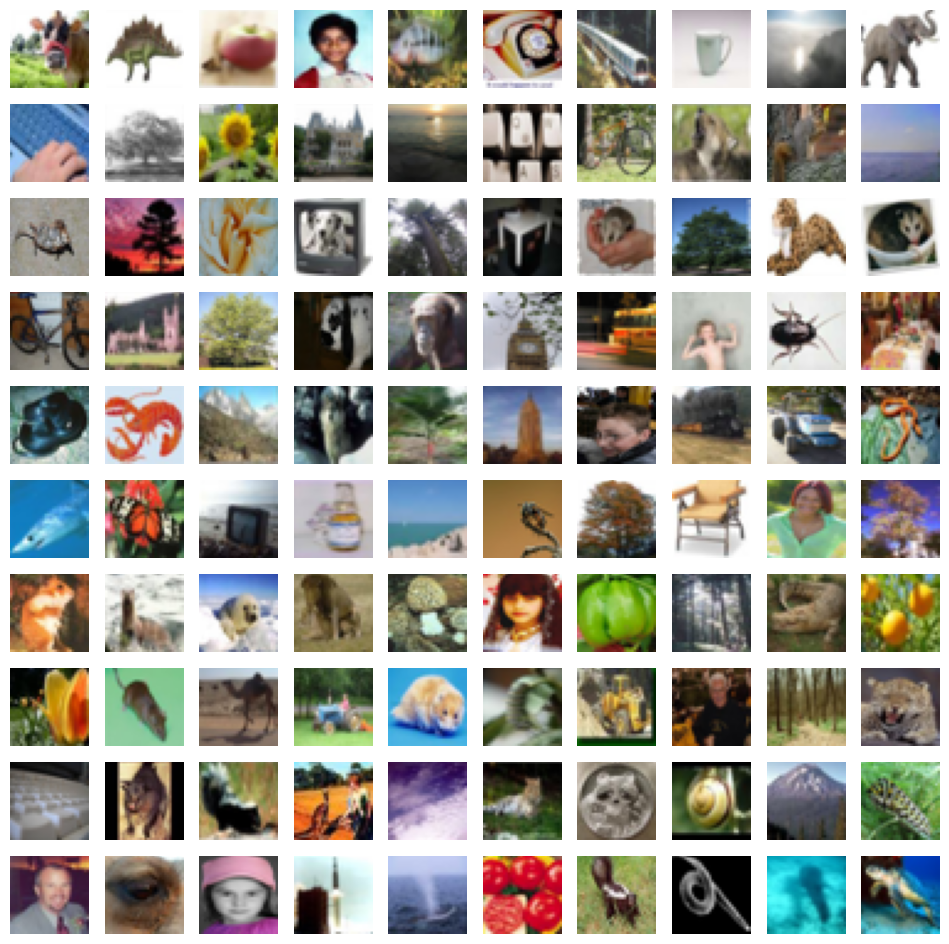

In [4]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

## Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [5]:
x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

##  Onehot encoding of the outputs

In [6]:
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(Y_test, num_classes = 100)

In [7]:
  x_train = x_train * 1.0/255

  x_val = x_val * 1.0/255

  X_test = X_test * 1.0/255

In [8]:
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


##  Image Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

##  Reduce Learning Rate if accuracy is not improving for 3 epochs

In [10]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

##  Importing the Resnet Model

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [12]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

##  Converting the output layer as per our dataset

In [13]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

### **Issue** : The Cifar images are of the shape 32,32,3 and resnet model is trained on images of 224,224,3

### *Solution* : Rezise Images - this is a costly operation and i eventually ran out of memory many a times

### **Used Solution** : Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks
* ### 32 * 7 = 224


### Stochastic gradient descent optimizer with momentum.

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

Compile the model

In [15]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

We now Train the model on images. we are also checking to see if validation accuracy doesnt improve we will reduce learning rate though the callback

In [16]:
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 64),
    validation_data = (x_val, y_val),
    epochs = 15,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/15
625/625 [==============================] - 366s 556ms/step - loss: 3.7195 - accuracy: 0.1670 - val_loss: 8.8790 - val_accuracy: 0.0095 - lr: 0.0010
Epoch 2/15
625/625 [==============================] - 347s 555ms/step - loss: 2.5198 - accuracy: 0.3708 - val_loss: 2.0063 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 3/15
625/625 [==============================] - 347s 555ms/step - loss: 2.0960 - accuracy: 0.4572 - val_loss: 1.7409 - val_accuracy: 0.5285 - lr: 0.0010
Epoch 4/15
625/625 [==============================] - 347s 555ms/step - loss: 1.8564 - accuracy: 0.5066 - val_loss: 1.5711 - val_accuracy: 0.5663 - lr: 0.0010
Epoch 5/15
625/625 [==============================] - 347s 555ms/step - loss: 1.6841 - accuracy: 0.5442 - val_loss: 1.4474 - val_accuracy: 0.5954 - lr: 0.0010
Epoch 6/15
625/625 [==============================] - 347s 554ms/step - loss: 1.5789 - accuracy: 0.5670 - val_loss: 1.3762 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 7/15
625/625 [==========================

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, None, None, None   0         
 D)                          )                                   
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)               1

## Plot accuracy and Loss

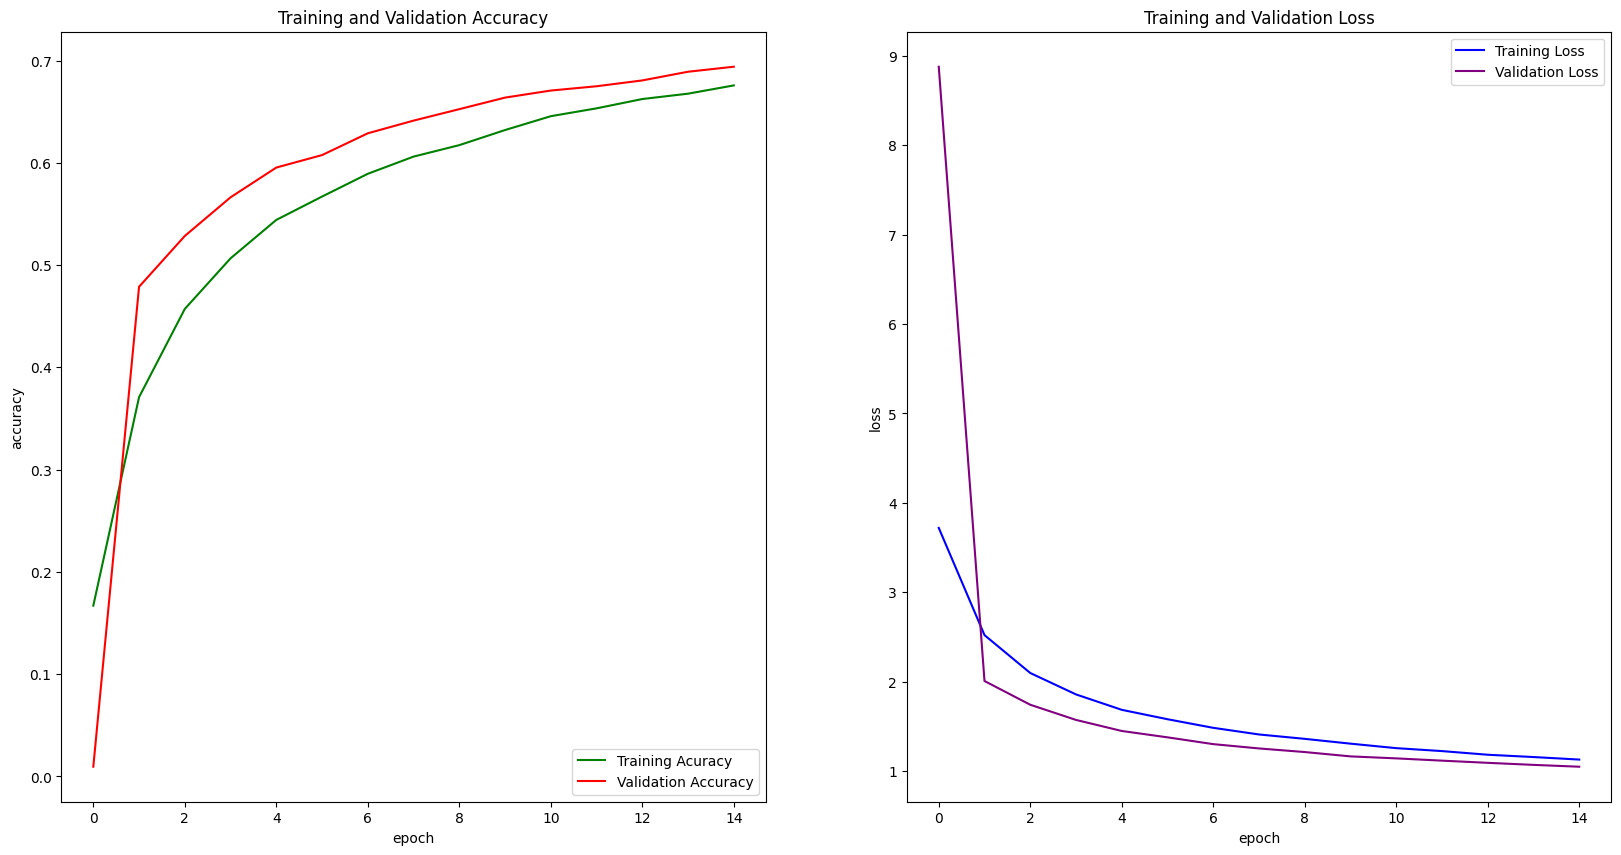

In [18]:
plot_acc_loss(result)


## Predictions,Accuracy and Confusion Matrix
### ** Requires modification for proper format **

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)


313/313 [==============================] - 30s 91ms/step
(10000,) (10000,)


In [20]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.6895


In [21]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[85,  0,  0, ...,  0,  0,  0],
       [ 0, 69,  0, ...,  0,  0,  0],
       [ 0,  1, 59, ...,  0,  3,  0],
       ...,
       [ 0,  0,  0, ..., 69,  0,  0],
       [ 0,  0,  5, ...,  1, 40,  0],
       [ 0,  0,  1, ...,  0,  0, 81]])